<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/ml-lote/direct_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install smt

In [2]:
from argparse import ArgumentParser
from collections import defaultdict
from math import ceil, sin
from math import floor


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.modules.container import T

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib as mpl

In [3]:
############### Setup Experiment ###############
y0 = [np.pi / 4, 0]
step_size = 0.01
t_start = 0.0
t_end = 4*np.pi
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, step_size)  # 0.0 , 0.01

g = 1.0  # gravitational acceleration [m/s^2]
l = 1.0  # length of pendulum [m]

model = 'vanilla'
n_epochs = 2000
device = 'cpu'
subsample_every = int(2.5 / step_size)

In [4]:
############### Define Derivative ###############
def f(t, y):
    θ, ω = y  # state variables go in
    g = 1.0
    l = 1.0
    # Las letras griegas se escriben con una extension en VSC
    dω = -(g / l) * np.sin(θ)
    dθ = ω  # special case (common for mechanical systems), the state variable ω is per definition dθ

    return dθ, dω  # derivatives of state variables go out

In [25]:
############### Solve ODE ###############

res = solve_ivp(f, t_span, t_eval=t_eval, y0=y0, method="RK45")
print(t_span)
print()
print(t_eval)

[0.7853981633974483, 0]

In [ ]:
θ, ω = res.y

The cmap() function is a function provided by Matplotlib's colormap library that takes a value between 0 and 1 and returns a corresponding color.

The value c[it + steps // 2] is the value in the c array that corresponds to the center point of the current segment being plotted. For example, if steps is 10, it is 0, and c is an array of 10 values, then c[it + steps // 2] would be the value at index 5 in c.

The value c[it + steps // 2] is then passed to the cmap() function, which maps it to a color and returns that color. This color is used as the color for the current segment being plotted.

This process is repeated for each segment of the curve. The color of each segment is determined by the value in c at the center point of the segment, which is mapped to a color using the cmap() function.

In [6]:
def plot_colored(ax, x, y, c, cmap=plt.cm.jet, steps=10, **kwargs):
    """
    This function appears to be a function that plots a series of segments of a curve on a 2D plot, 
    where each segment is colored differently according to a corresponding value in the c array. 
    The color of each segment is determined by mapping the value in c to a color in the colormap 
    cmap using the cmap() function.

    The curve is plotted in segments of steps points at a time. The function starts at the first 
    point of the curve and plots a segment of steps points, then moves steps points forward and
     plots the next segment, and so on until it has plotted the entire curve.

    The **kwargs parameter allows the user to pass additional arguments to the plot() function, 
    such as the line style or marker type.
    """
    # Normalizar c
    c = np.asarray(c)
    c -= c.min()
    c = c / c.max()

    it = 0
    while it < c.size - steps:
        x_segm = x[it : it + steps + 1]
        y_segm = y[it : it + steps + 1]
        # No puedes llegar a c.size porque indexas fuera del rango
        c_segm = cmap(c[it + steps // 2])
        ax.plot(x_segm, y_segm, c=c_segm, **kwargs)
        it += steps

In [7]:
def xavier_init(module):
        for m in module.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)

In [8]:
def construct_network(input_dim, output_dim, hidden_dim, hidden_layers):

        layers = [nn.Linear(input_dim, hidden_dim), nn.Softplus()]
        for _ in range(hidden_layers):
            # It seems like Softplus is the one that works well
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Softplus()])
        layers.append(nn.Linear(hidden_dim, output_dim))

        net = nn.Sequential(*layers).double().to(device)
        xavier_init(net)
        return net

In [9]:
hidden_dim = 32
hidden_layers = 5

In [28]:
t = torch.tensor(t_eval, device=device, requires_grad=True)
print(t)


defaultdict(<function <lambda> at 0x7f8a40f17c10>, {})


In [38]:
d = defaultdict(lambda: 4)
print(d["a"])

e = defaultdict(lambda: list())
print(e[(2,3)])

r = defaultdict(lambda: defaultdict(list))
print(r["W"])
print()
r["Q"][(4,5)].append(2222)
print(r["Q"][(4,5)])

4
[]
defaultdict(<class 'list'>, {})

[2222]


In [39]:
d = defaultdict(lambda: defaultdict(list))

# Add a new key 'a' to the outer default dictionary
d['a']['b'].append(1)

# Print the value of d
print(d)

defaultdict(<function <lambda> at 0x7f8a31b07940>, {'a': defaultdict(<class 'list'>, {'b': [1]})})


Here, the key 'a' was added to the outer default dictionary, and the inner default dictionary's key 'b' was used to add the value 1 to a list.

defaultdict(lambda: defaultdict(list)) is a Python expression that creates a default dictionary with default dictionaries as values.

A default dictionary is a dictionary-like object that provides a default value for a key that does not exist in the dictionary. This can be useful if you want to automatically create a new entry in the dictionary for a key that does not exist, rather than raising a KeyError.

The default value for the keys in this default dictionary is another default dictionary, with lists as values. This means that you can access the inner default dictionary using the outer default dictionary's keys, and you can access the lists using the inner default dictionary's keys.

In [ ]:
losses = defaultdict(lambda: defaultdict(list))
print(losses)

In [11]:
# `torch.autograd.grad` supports only lists of scalar values (e.g. single evaluation of network).
# however the function accepts a list of these.
def listify(A):
    """
    This is a simple Python function that takes a 2D array A and returns a flat list of 
    all the elements in A.

    The function does this by using a list comprehension to iterate over the elements in 
    the flattened version of A, which is obtained using the flatten() method of the 
    ndarray object. The flatten() method returns a copy of the array collapsed into one 
    dimension, so that all the elements in the array are in a single, flat list.

    Note that this function will work only for 2D arrays, because it assumes that A is a 
    2D array and uses the flatten() method, which is only available for 2D arrays. 
    If you pass a 1D array or a higher-dimensional array to this function, it will raise an error.
    """
    return [a for a in A.flatten()]

In [40]:
A = np.array([[1, 2, 3], [4, 5, 6]])
listify(A)


[1, 2, 3, 4, 5, 6]

In [45]:
print(res.y.shape)

(2, 1257)


In [42]:
y_train = torch.tensor(res.y[:, ::subsample_every]).to(device)
t_train = torch.tensor(t_eval[::subsample_every], requires_grad=True).to(device)
θω_pred = None

250

In [49]:
print(y_train.shape)
print(y_train)
print()
print(t_train.shape)
print(t_train)

torch.Size([2, 6])
tensor([[ 0.7854, -0.5852,  0.0782,  0.4701, -0.7685,  0.6752],
        [ 0.0000, -0.5033,  0.7610, -0.6062,  0.1452,  0.3797]],
       dtype=torch.float64)

torch.Size([6])
tensor([ 0.0000,  2.5000,  5.0000,  7.5000, 10.0000, 12.5000],
       dtype=torch.float64, requires_grad=True)


Vanilla

construct_network(input_dim->time, output_dim->(theta, omega), hidden_dim->32, hidden_layers->5)

In [13]:
nn_vanilla = construct_network(1, 2, hidden_dim, hidden_layers)

In [14]:
opt_vanilla = torch.optim.Adam(nn_vanilla.parameters())

In [15]:
for epoch in tqdm(range(n_epochs), desc="vanilla: training epoch"):

            # 1. Forward pass
            out = nn_vanilla(t_train.unsqueeze(-1)).T

            # 2. Calculate loss
            loss_collocation = F.mse_loss(out, y_train)

            # 3. Zero grad
            nn_vanilla.zero_grad()

            # 4. Backward pass
            loss_collocation.backward()

            # 5. Update weights and biases
            opt_vanilla.step()
            
            losses["vanilla"]["collocation"].append(loss_collocation.item())

vanilla: training epoch: 100%|██████████| 2000/2000 [00:04<00:00, 408.99it/s]


t.unsqueeze(-1) is a method of a PyTorch tensor t that inserts a new dimension with size 1 at the given position in the tensor's shape.

The position of the new dimension is specified by the argument -1, which means that the new dimension will be inserted at the last position in the tensor's shape. For example, if t is a 2D tensor with shape (3, 4), then t.unsqueeze(-1) will return a 3D tensor with shape (3, 4, 1).

The unsqueeze() method is useful for adding a new dimension to a tensor when you need to perform certain operations that require a tensor with a specific shape, or when you need to concatenate or stack tensors along a specific dimension.

In [ ]:
# Example
t_exp= torch.tensor([1, 2, 3, 4, 5])
print(t.shape)  # prints (5,)

t_exp= t.unsqueeze(-1)
print(t.shape)  # prints (5, 1)


In this example, t_exp is a 1D tensor with shape (5,). When the unsqueeze() method is called with -1 as the argument, it inserts a new dimension with size 1 at the last position in the tensor's shape, resulting in a 2D tensor with shape (5, 1).

Note that when a 1D tensor is printed, its shape is represented with a trailing comma, such as (5,), to distinguish it from a scalar value. The shape of a 1D tensor is always of the form (N,), where N is the size of the tensor along the first dimension.

The nn_vanilla() function will return the predicted output values for the input tensor t.


The detach() method will separate the output tensor from the computation graph and prevent any gradient computation on it. This is often done when the output tensor is not needed for further gradient computation, such as when evaluating the model on a test set.


The output tensor is moved to the CPU using the cpu() method and its transpose is taken using the T attribute. The transpose operation switches the rows and columns of the tensor, so that the first dimension becomes the second dimension and vice versa.


The final result of this expression is assigned to the variable θω_pred, which is the transpose of the output tensor of the model, with the gradients detached and the tensor moved to the CPU.

In [62]:
# with t.unsqueeze(-1) we add a dimension and this way we create a column vector 

θω_pred = nn_vanilla(t.unsqueeze(-1)).detach().cpu().T
print(θω_pred)
 
print(θω_pred.shape) # num outputs, batch size

tensor([[ 7.8736e-01,  7.6782e-01,  7.4837e-01,  ...,  7.1601e-01,
          7.2525e-01,  7.3450e-01],
        [ 1.7198e-04, -2.0658e-02, -4.1527e-02,  ...,  3.7334e-01,
          3.7228e-01,  3.7121e-01]], dtype=torch.float64)
torch.Size([2, 1257])


first axis corresponds to the number of output values predicted by the model and the second axis corresponds to the batch size.

In [63]:
θω_pred[:1] # theta

tensor([[0.7874, 0.7678, 0.7484,  ..., 0.7160, 0.7253, 0.7345]],
       dtype=torch.float64)

In [ ]:
def plot_predictions(model, θω_pred):
    ω_numerical = np.diff(θω_pred[0]) / step_size

    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True) is a line of code in Matplotlib that creates
    #  a figure with two subplots (axes) arranged in a single column.

    # The plt.subplots() function creates a figure and a set of subplots, and returns a tuple 
    # (fig, ax) where fig is the figure object and ax is an array of subplot objects. In this case, 
    # the subplots() function is called with the arguments (2, 1, sharex=True), which means that it 
    # will create a figure with two subplots arranged in a single column and with the x-axis shared 
    # between the two subplots.

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    # To set the window title of a Matplotlib figure in Python, you can use the set_window_title
    # method of the figure's canvas manager. 

    # Note that this method only works if the Matplotlib backend is interactive (e.g., if you are 
    # using the qt5 backend or the tkagg backend). If the Matplotlib backend is not interactive, 
    # this method will have no effect. ->  THIS IS THE CASE IN COLAB
    

    # fig.canvas.manager.set_window_title(model)
    ax1.set_ylabel("θ(t)")
    ax2.set_ylabel("ω(t)")
    ax2.set_xlabel("t")

    ax1.plot(t_eval, θ, c="black", label="true")
    ax1.plot(t_eval, θω_pred[0], c="b", linestyle="--", label="predicted")

    ax2.plot(t_eval, ω, c="black", label="true")
    ax2.plot(t_eval, θω_pred[1], c="r", linestyle="--", label="predicted")
    ax2.plot(
        t_eval[1:],
        # ω_numerical.T,
        ω_numerical,
        c="r",
        linestyle="dotted",
        label="numerical",
    )

    ax1.scatter(
        t_eval[::subsample_every],
        res.y[:, ::subsample_every][0],
        c="black",
        linestyle="None",
        label="collocation point",
    )

    ax2.scatter(
        t_eval[::subsample_every],
        res.y[:, ::subsample_every][1],
        c="black",
        linestyle="None",
        label="collocation point",
    )

    ax2.legend()
    plt.tight_layout()

In [66]:
ω_numerical = np.diff(θω_pred[0]) / step_size
print(ω_numerical.shape)

(1256,)


In [68]:
r = np.arange(0,10)
np.diff(r)

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In this case, the code ω_numerical = np.diff(θω_pred[0]) / step_size will calculate the finite difference of the elements along the second axis of θω_pred, which is the axis corresponding to the batch size.

θω_pred[0] is the first element along the first axis of θω_pred, which is the axis corresponding to the number of output values predicted by the model. This means that θω_pred[0] is a 1D tensor of shape (batch_size,) that contains the output values predicted by the model for a single output.

The np.diff() function calculates the finite difference of the elements along a given axis of an array. In this case, np.diff(θω_pred[0]) calculates the finite difference of the elements along the second axis of θω_pred, which is the axis corresponding to the batch size. The result is an array of shape (batch_size-1,), which contains the differences between consecutive elements along the second axis of θω_pred.

The step_size variable is a scalar value that represents the size of the step used in the finite difference calculation. Dividing the finite differences by the step size will give an approximation of the derivative at each point.

Finally, the result is assigned to the variable ω_numerical, which is the numerical approximation of the derivative of the model's output with respect to the input tensor t for a single output value.

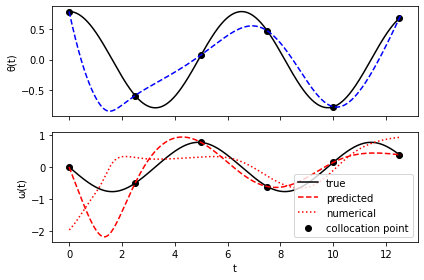

In [19]:
plot_predictions(model, θω_pred)

In [18]:
def plot_losses(model, losses):
    fig, ax = plt.subplots()
    fig.canvas.manager.set_window_title(f"loss terms '{model}'")

    for loss_name, loss in losses.items():
        ax.plot(loss, label=loss_name)

    ax.legend()
    ax.set_xlabel("epoch")

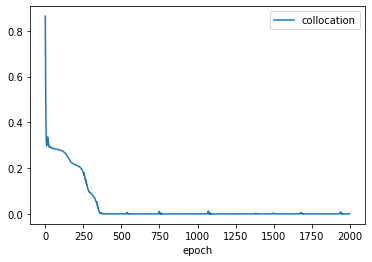

In [20]:
plot_losses(model, losses[model])

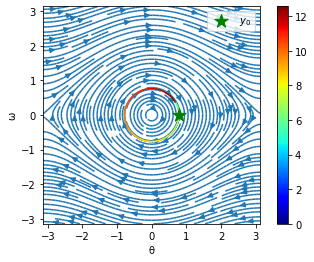

In [21]:
fig = plt.figure()
x, y = np.meshgrid(
    np.arange(-np.pi, np.pi, 0.01),
    np.arange(-np.pi, np.pi, 0.01),
)
dθ, dω = f(None, (x, y))
plt.streamplot(x, y, dθ, dω, density=2)
plt.xlabel("θ")
plt.ylabel("ω")
fig.canvas.manager.set_window_title(f"phase portrait '{model}'")

ax = plt.gca()
plot_colored(ax, θ, ω, t_eval)
cmap = plt.cm.jet

norm = mpl.colors.Normalize(vmin=t_eval.min(), vmax=t_eval.max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

# draw initial state
plt.scatter(θ[0], ω[0], label="$y_0$", marker="*", c="g", s=200, zorder=100)
plt.legend(loc="upper right")
ax.set_aspect(1)

plt.show()